In [1]:
from jupyter_imports import *
from copy import deepcopy

In [2]:
# run only once
from utils.MyLogger import ExecutionLogger # use 'prod' for remote after cache_tmp
start = datetime(2022,7,10,0)#,tzinfo=timezone.utc)
dirname = os.path.join(os.sep, 'tmp','prod','tradeexecutor')#,'prod')
ExecutionLogger.batch_summarize_exec_logs(dirname=dirname,start=start,add_history_context=False,rebuild=True)

'moved 0 logs to unreadable'

In [3]:
files = ['all_by_clientOrderId','all_by_coin','all_by_symbol','all_order_manager','all_parameters']
original = {file:pd.read_csv(os.path.join(os.sep, dirname,f'{file}.csv'),index_col=0) for file in files}

In [4]:
cmap = cm.get_cmap('Spectral')
#fig, ax = plt.subplots(1)

## parameters for reference

In [5]:
all_parameters = original['all_parameters']
all_parameters['hash'] = all_parameters['timestamp'].apply(lambda x: pd.util.hash_pandas_object(all_parameters.groupby('timestamp').get_group(x).astype(str)).sum())
all_parameters['param_index'] = all_parameters['hash'].apply(lambda h: list(all_parameters['hash'].unique()).index(h))
all_parameters.drop(columns=['hash'],inplace=True)
param_map = all_parameters.set_index('timestamp')['param_index'].to_dict()
param_map

{1659486333341.0798: 0,
 1659486859577.1611: 1,
 1659463742659.677: 2,
 1659466102473.86: 3,
 1659463482731.886: 4}

In [7]:
indexed = deepcopy(original)
#for df in indexed.values():
#    df['param_index'] = df['timestamp'].apply(lambda x:param_map[x])
#colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(all_parameters['param_index'].unique())))

### slippage, fees in bps. filled in USD

In [8]:
print(indexed['all_by_symbol'].describe())
indexed['all_by_symbol']

       time_to_execute  slippage_bps  fee  filledUSD
count     3.000000e+00      4.000000  4.0   4.000000
mean      7.708493e+06     13.909238  0.0   3.960150
std       1.334470e+07     65.658324  0.0   4.102115
min       2.200090e+02    -41.508973  0.0  -1.062500
25%       3.930213e+03    -31.613676  0.0   2.615725
50%       7.640417e+03     -3.139055  0.0   3.960150
75%       1.156263e+07     42.383859  0.0   5.304575
max       2.311762e+07    103.424034  0.0   8.982800


,index,time_to_execute,slippage_bps,fee,filledUSD,coin
0,AAVE/USD,2.311762e+07,103.424034,0.0,3.8418,AAVE
1,MKR/USD:USD,7.640417e+03,-28.315243,0.0,-1.0625,MKR
2,UNI/USD,2.200090e+02,-41.508973,0.0,4.0785,UNI
3,average,NaN,22.037133,0.0,8.9828,NaN


### slippage distribution

In [9]:
print(indexed['all_by_coin'].describe())
indexed['all_by_coin']

       premium_vs_inception_bps  perleg_fee_bps  perleg_filled_USD
count                  4.000000             4.0           4.000000
mean                  27.818476             0.0           2.245700
std                  131.316647             0.0           1.646271
min                  -83.017947             0.0           0.531250
25%                  -63.227351             0.0           1.573488
50%                   -6.278110             0.0           1.980075
75%                   84.767717             0.0           2.652287
max                  206.848069             0.0           4.491400


,index,premium_vs_inception_bps,perleg_fee_bps,perleg_filled_USD
0,AAVE,206.848069,0.0,1.92090
1,MKR,-56.630486,0.0,0.53125
2,UNI,-83.017947,0.0,2.03925
3,average,44.074267,0.0,4.49140


# tick to ack

,index,symbol,coin,order_ref,pending_local,pending_to_ack_local,mid_at_pending,amount,filled,price,fee,last_fill_local
0,chase_AAVE/USD_1659486816581,AAVE/USD,AAVE,93.750,1.659487e+12,697.710938,93.7500,0.010,0.010,93.770,0.0,1.659487e+12
1,new_AAVE/USD_1659463703872,AAVE/USD,AAVE,94.390,1.659464e+12,121.558838,97.0800,0.020,0.020,97.090,0.0,1.659464e+12
2,new_AAVE/USD_1659466080112,AAVE/USD,AAVE,97.800,1.659466e+12,124.056885,96.2050,0.010,0.010,96.230,0.0,1.659466e+12
3,new_MKR/USD:USD_1659463437098,MKR/USD:USD,MKR,1059.500,1.659463e+12,112.476318,1061.7500,-0.001,-0.001,1062.500,0.0,1.659463e+12
4,new_UNI/USD_1659486289959,UNI/USD,UNI,8.191,1.659486e+12,126.343018,8.1565,0.500,0.500,8.157,0.0,1.659486e+12


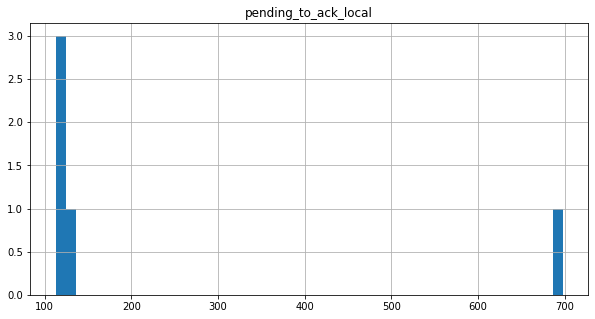

In [10]:
by_clientOrderId = indexed['all_by_clientOrderId']
tick_to_order_local = by_clientOrderId[['pending_to_ack_local']]
tick_to_order_local.hist(bins=50,figsize=(10,5))
tick_to_order_local.describe()
by_clientOrderId

# remote vs local (~ round trip)

,round_trip
count,32.000000
mean,76.107361
std,196.300370
min,0.030273
25%,30.350586
50%,38.876953
75%,58.698120
max,1141.642090


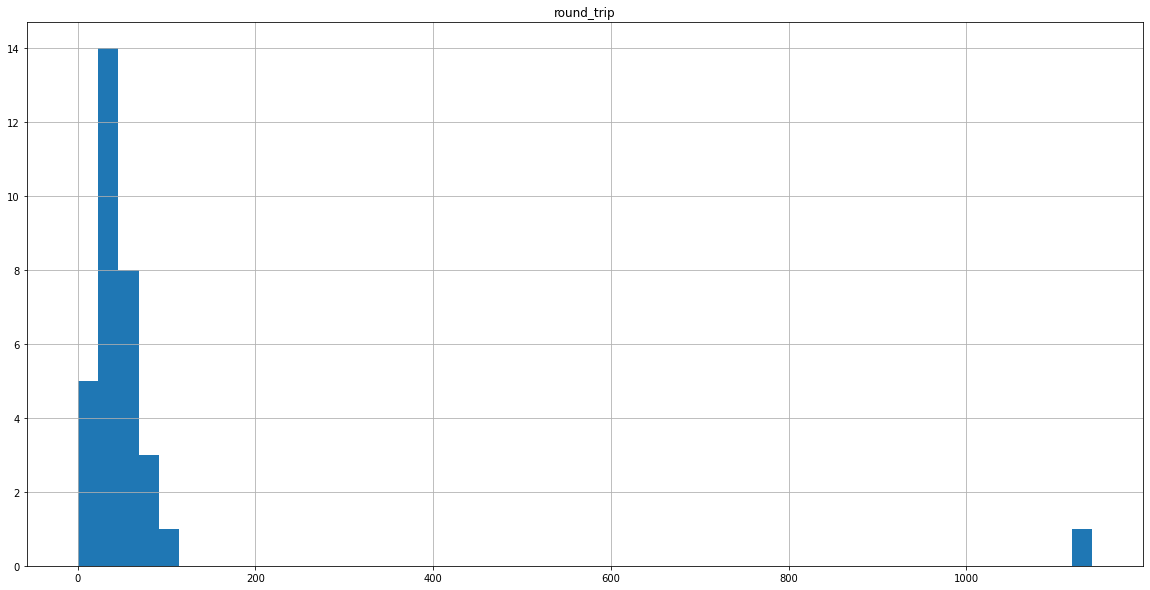

In [12]:
round_trip = pd.DataFrame(columns=['round_trip'], data = 2*(indexed['all_order_manager']['timestamp']-indexed['all_order_manager']['remote_timestamp']))
round_trip.hist(bins=50,figsize=(20,10))
round_trip.describe()
#indexed['all_order_manager'][['timestamp','remote_timestamp']] - indexed['all_parameters']['timestamp'].squeeze()